# 📊 03 - Visual Comparison of Ground Truth vs Predictions

🧭 **Objective:**
This notebook visualizes and compares the ground truth and predicted crime patterns. We focus on:

- The **spatial distribution** of crime counts
- The generated **hotspots** from both actual and predicted data
- Visual alignment (or discrepancies) between model predictions and real-world outcomes

These visualizations help contextualize the uncertainty-aware evaluations, offering **intuitive insight** into model strengths and limitations in real data scenarios.

# 📦 Load Libraries and Modules

We load the required Python libraries for spatial visualization and processing, as well as custom project modules for:

- Spatial grid transformations
- Hotspot extraction logic
- Data partitioning for evaluation
- Visualization tools (e.g., side-by-side maps, temporal overlays)

This notebook assumes the project root is accessible to resolve relative imports.


In [13]:
import os
import sys
import json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../.."))
sys.path.insert(0, project_root)

# Load modules 
from src.utils.spatial_processing import predictions_to_grid, define_hotspot_by_crimes, grid_to_dataframe
from src.utils.data_partition import temporal_split

import warnings
warnings.filterwarnings("ignore")

## ⚙️ Load Configuration, Model, and Data

We load the project configuration (`config.json`) and extract relevant settings for:

- Hotspot definition strategy (`by_crimes` or `by_cells`)
- Train, calibration, and test period durations
- File paths for model and geographic information

We also:

- Load the trained **naive model** from disk.
- Load and prepare the **geographic shape file** representing Chicago police beats.
- Load the **preprocessed dataset** (`df_used.csv`) with aggregated crime counts.
- Perform a temporal split into training, calibration, and test sets.
- Generate **spatio-temporal grids** (`grid_true`, `grid_naive`) from test data and predictions for downstream visualizations.

In [14]:
# Load global config 
config_path = os.path.join("../../", "config.json")
with open(config_path, 'r') as f:
    config = json.load(f)

# Define hotspot method from config
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
hotspot_method = config["evaluation"].get("hotspot_definition", "by_cells")  # default

# Partition data
partition_config = config["data_partition"]
days_per_month = 30
train_days = partition_config["train_months"] * days_per_month
calibration_days = partition_config["calibration_months"] * days_per_month
test_days = partition_config["test_months"] * days_per_month

# Paths
data_dir = "../../data/real_data/Chicago/"
map_path = os.path.join(data_dir, "beat_to_coord_map.json")

path_dir="../../results/models/real_data/Chicago/"
naive_model = joblib.load(os.path.join(path_dir,"naive_cell_model.pkl"))


# Define path
data_path = "../../../../../uncertainty-informed-data/real_data/Chicago"
geometry_name = "PoliceBeatDec2012_20250410.csv"
geometry_path = os.path.join(data_path, geometry_name)

# Load data
gdf = gpd.read_file(os.path.abspath(geometry_path))
gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries.from_wkt(gdf['the_geom'], crs=4326), data=gdf
)

# Load
df=pd.read_csv(os.path.join(data_dir,"df_used.csv"))
with open(map_path) as f:
    beat_to_coord_map = json.load(f)

rows, cols = tuple(df[["row","col"]].max()+1)
grid_size = (rows, cols)

df_train, df_calib, df_test = temporal_split(df, train_days, train_days + calibration_days, train_days + calibration_days + test_days)

# Define features
features = ["timestep", "row", "col"]
target = "count"

X_test, y_test = df_test[features], df_test[target]

naive_pred = naive_model.predict(X_test)

# Convert to spatial grids
grid_true, grid_naive = predictions_to_grid(X_test, y_test, naive_pred, grid_size,aggregate=False)

## 🔥 Define Hotspots and Save Prediction Mask

We compute the hotspot masks:

- `hotspot_naive`: derived from the **average naive model prediction** across the test set.
- `hotspot_optimal`: derived from the **ground truth average** over the same period.

We also:

- Convert these grids to a DataFrame structure with `Beat` IDs for future spatial joins with geographic shapes.
- Save the predicted hotspot mask to disk for later use in evaluations and comparison.

The predicted hotspot mask is saved to:
`results/hotspots/real_data/Chicago/naive_hotspot_prediction.pkl`





In [15]:
# Define hotspot masks

hotspot_naive = define_hotspot_by_crimes(grid_naive.sum(axis=0), hotspot_percentage)
hotspot_optimal = define_hotspot_by_crimes(grid_true.sum(axis=0), hotspot_percentage)

coord_to_beat_map = {tuple(v): k for k, v in beat_to_coord_map.items()}


df_true_w_beat=grid_to_dataframe(grid_true.mean(axis=0), coord_to_beat_map, value_name="Count Crimes")
df_naive=grid_to_dataframe(grid_naive.mean(axis=0), coord_to_beat_map, value_name="Count Crimes")

hotspots_dir="../../results/hotspots/real_data/Chicago/"
os.makedirs(hotspots_dir, exist_ok=True)
joblib.dump(hotspot_naive, os.path.join(hotspots_dir,"naive_hotspot_prediction.pkl"))


['../../results/hotspots/real_data/Chicago/naive_hotspot_prediction.pkl']

# 🗺️ Crime Intensity Maps: Ground Truth vs Naive Prediction

We visualize the **spatial distribution** of crime intensity over the test period using:

- **Left panel**: Aggregated crime counts from the **ground truth** data.
- **Right panel**: Aggregated predictions from the **NaivePerCell** model.

The intensity (color scale) is synchronized across both maps to enable visual comparison.


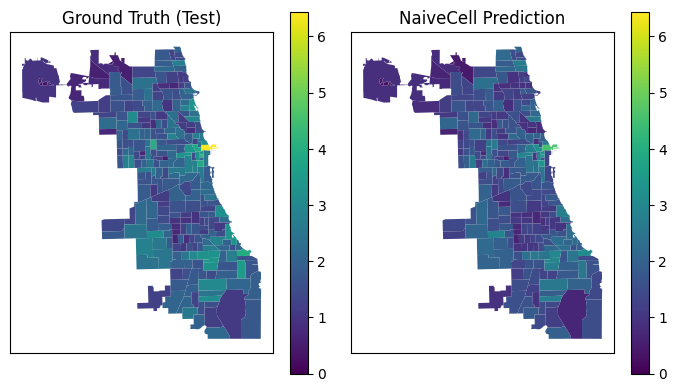

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
max_crimes=max(df_true_w_beat["Count Crimes"].max(),df_naive["Count Crimes"].max())
for ax, grid, title in zip(axes, [df_true_w_beat,df_naive], ["Ground Truth (Test)", "NaiveCell Prediction"]):
    gdf[["BEAT_NUM","geometry"]].merge(grid,how="left",left_on="BEAT_NUM",right_on="beat").plot("Count Crimes",legend=True,ax=ax,vmax=max_crimes,vmin=0)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# 🔥 Hotspot Comparison: Ground Truth vs Naive Prediction

We visualize **binary hotspot maps** generated by:

- **Ground Truth (left)**: Identifies areas with the highest observed crime counts.
- **Naive Model Prediction (right)**: Identifies areas with the highest predicted counts using the naive per-cell model.

Each cell is colored based on whether it was selected as part of the top-X% crime areas (defined via the `hotspot_percentage` parameter).


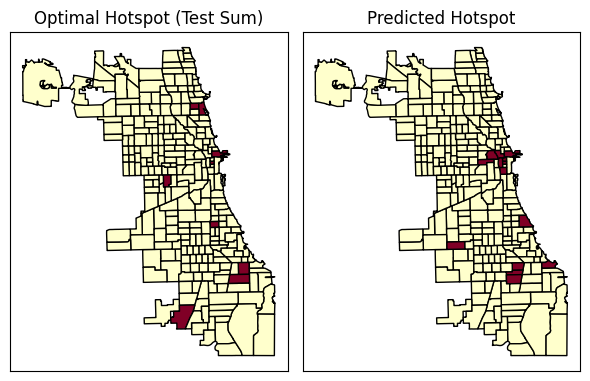

In [22]:
df_hotspot_optimal=grid_to_dataframe(hotspot_optimal, coord_to_beat_map, value_name="HotSpot")
df_hotspot_naive=grid_to_dataframe(hotspot_naive, coord_to_beat_map, value_name="HotSpot")

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
for ax, grid, title in zip(axes, [df_hotspot_optimal,df_hotspot_naive], ["Optimal Hotspot (Test Sum)", "Predicted Hotspot"]):
    gdf[["BEAT_NUM","geometry"]].merge(grid,how="left",
                                       left_on="BEAT_NUM",right_on="beat").plot("HotSpot",legend=False,
                                                                                ax=ax,vmax=None,vmin=0,
                                                                                cmap="YlOrRd",edgecolor="black")
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

fig.savefig("../../results/figures/hotspot_comparison.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# 🔄 Daily Hotspot Comparison (Random Timestep)

To assess **temporal variability** in predictions, we randomly select a day within the test set and compare:

- **Ground Truth Hotspots**: Based on the true crime counts for that day.
- **Naive Model Hotspots**: Based on the model's prediction for that same day.

This allows us to visually evaluate alignment and misalignment between prediction and reality over time.


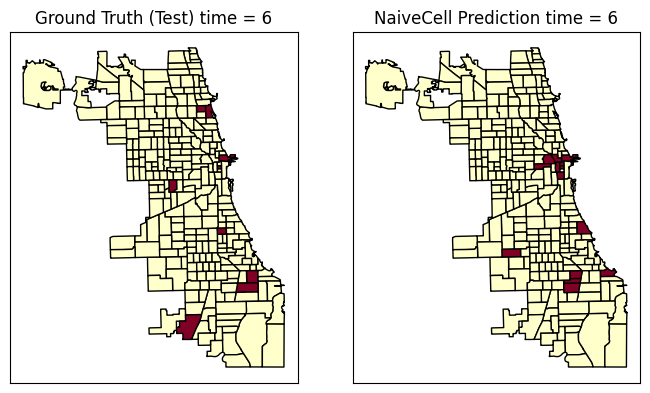

In [18]:
# Define hotspot masks
time_to_view=np.random.randint(test_days)

hotspot_naive = define_hotspot_by_crimes(grid_naive[time_to_view], hotspot_percentage)
hotspot_optimal = define_hotspot_by_crimes(grid_true[time_to_view], hotspot_percentage)

df_hotspot_optimal=grid_to_dataframe(hotspot_optimal, coord_to_beat_map, value_name="HotSpot")
df_hotspot_naive=grid_to_dataframe(hotspot_naive, coord_to_beat_map, value_name="HotSpot")

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
for ax, grid, title in zip(axes, [df_hotspot_optimal,df_hotspot_naive],
                           ["Ground Truth (Test) time = "+str(time_to_view), "NaiveCell Prediction time = "+str(time_to_view)]):
    gdf[["BEAT_NUM","geometry"]].merge(grid,how="left",
                                       left_on="BEAT_NUM",right_on="beat").plot("HotSpot",legend=False,
                                                                                ax=ax,vmax=None,vmin=0,
                                                                                cmap="YlOrRd",edgecolor="black")
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## 🕓 Random Daily Hotspot Snapshots

We randomly select **four different days** from the test set and visualize the **ground truth hotspots** for each.

This helps us understand:

- Temporal variability in crime distribution.
- Whether the same regions persistently appear as hotspots or shift over time.
- Baseline complexity of the hotspot prediction task.

Each subplot below shows the hotspot regions detected using the `define_hotspot_by_crimes` function based on actual crime counts.

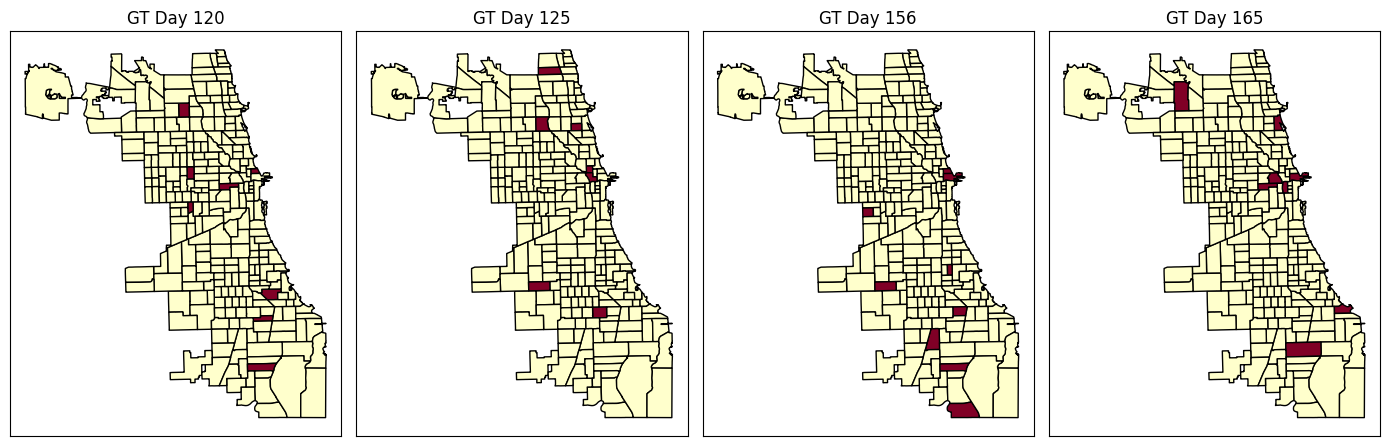

In [19]:
np.random.seed(42)
dias_aleatorios = np.random.choice(X_test["timestep"].unique(), size=4, replace=False)


masks_gt = []

for t in dias_aleatorios:
    idx = X_test["timestep"] == t
    X_day = X_test[idx]
    y_day = y_test[idx]

    grid_gt = np.zeros(grid_size)
    for r, c, v in zip(X_day["row"], X_day["col"], y_day):
        grid_gt[r, c] = v

    mask = define_hotspot_by_crimes(grid_gt, hotspot_percentage)
    df_mask=grid_to_dataframe(mask, coord_to_beat_map, value_name="HotSpot")
    masks_gt.append(df_mask)


mask_dict = {f"GT Day {t}": m for t, m in zip(dias_aleatorios, masks_gt)}


titles = list(mask_dict.keys())
masks = list(mask_dict.values())
ncols=4
n = len(masks)
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
axes = axes.flatten() if n > 1 else [axes]

for i in range(n):
    gdf[["BEAT_NUM","geometry"]].merge(masks[i],how="left",
                                       left_on="BEAT_NUM",right_on="beat").plot("HotSpot",legend=False,
                                                                                ax=axes[i],vmax=None,vmin=0,
                                                                                cmap="YlOrRd",edgecolor="black")

    axes[i].set_title(titles[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [20]:
df_hotspot_optimal
df_hotspot_naive

,row,col,HotSpot,beat
0,0,0,True,0111
1,0,1,True,0112
2,0,2,False,0113
3,0,3,False,0114
4,0,4,False,0121
...,...,...,...,...
284,16,12,False,None
285,16,13,False,None
286,16,14,False,None
287,16,15,False,None


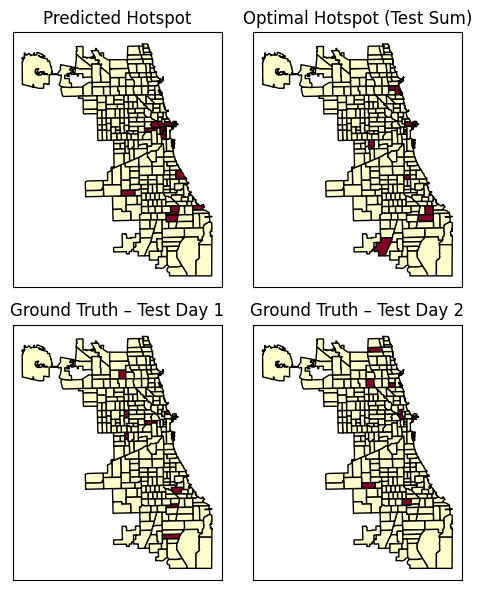

In [21]:
plot_data = {
    "Predicted Hotspot": df_hotspot_naive,
    "Optimal Hotspot (Test Sum)": df_hotspot_optimal,
}


for i, t in enumerate(dias_aleatorios[:2]):
    title = f"Ground Truth – Test Day {i + 1}"
    plot_data[title] = mask_dict[f"GT Day {t}"]


fig, axes = plt.subplots(2, 2, figsize=(5,6))
axes = axes.flatten()


for ax, (title, df_mask) in zip(axes, plot_data.items()):
    gdf[["BEAT_NUM", "geometry"]].merge(
        df_mask, how="left", left_on="BEAT_NUM", right_on="beat"
    ).plot("HotSpot", legend=False, ax=ax, cmap="YlOrRd", edgecolor="black")
    
    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

fig.savefig("../../results/figures/hotspot_comparison.pdf", format="pdf", bbox_inches="tight", dpi=300)

